<a href="https://colab.research.google.com/github/ali-unlu/Time-Series-Analysis-with-Facebook-Prophet/blob/main/Time_Series_Analysis_with_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Temperature Time Series Analysis with Facebook Prophet

Global warming is the ongoing rise of the average temperature of the Earth's climate system and has been demonstrated by direct temperature measurements and by measurements of various effects of the warming - Wikipedia

So a dataset on the temperature of major cities of the world will help analyze the same. Also weather information is helpful for a lot of data science tasks like sales forecasting, logistics etc.

# 1. Data and preprocessing 

Data comes from Kaggle and it could be reached from [here](https://www.kaggle.com/sudalairajkumar/daily-temperature-of-major-cities). Thanks to University of Dayton, the dataset is available as separate txt files for each city. The data is available for research and non-commercial purposes only. Please refer to [this page](http://academic.udayton.edu/kissock/http/Weather/default.htm) for license.

 In this dataset, it includes daily average temperature values collected as Fahrenheit over different regions, countries, cities over the years from about 1995 to 2020.

 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Python/IBM Machine Learning/Time Series and Survival Analysis')

Mounted at /content/drive


In [3]:
# Setup
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
import seaborn as sns

import fbprophet # necesssary for producing P D Q
import statsmodels.api as sm

os.chdir('/content/drive/MyDrive/Python/IBM Machine Learning/Time Series and Survival Analysis/assignment')


import pandas as pd
from datetime import datetime


In [4]:
df = pd.read_csv('city_temperature.csv', index_col=False)

Since the data includes many cities, I select only Istanbul from the list. 

In [5]:
df= df[(df.Country =='Turkey') & (df.City == 'Istanbul')]
df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
1102318,Middle East,Turkey,NaN,Istanbul,1,1,1995,55.0
1102319,Middle East,Turkey,NaN,Istanbul,1,2,1995,57.1
1102320,Middle East,Turkey,NaN,Istanbul,1,3,1995,44.4
1102321,Middle East,Turkey,NaN,Istanbul,1,4,1995,47.6
1102322,Middle East,Turkey,NaN,Istanbul,1,5,1995,44.1


### Missing values
During the EDA, some values in temperature are missing (-99). Let's first check out how many variables are missing. We noticed that there are 30 values are missing and we replace then with ffill function. 

In [6]:
"""-99 is put in place of missing values. 
We will have to forward fill with the last non missing value before -99
"""
df["AvgTemperature"] = np.where(df["AvgTemperature"] == -99, np.nan, df["AvgTemperature"])
df.isnull().sum()



Region               0
Country              0
State             9266
City                 0
Month                0
Day                  0
Year                 0
AvgTemperature      30
dtype: int64

In [7]:
df["AvgTemperature"] = df["AvgTemperature"].ffill()
df.isnull().sum()

Region               0
Country              0
State             9266
City                 0
Month                0
Day                  0
Year                 0
AvgTemperature       0
dtype: int64

### Celsius Conversion 
Finally, we can convert AvgTemperature from Fahrenhei to Celsius

Formula (°F − 32) × 5/9.

In [8]:
df['AvgTemperature'] = (df['AvgTemperature']  -32) * 5/9 


### Basic graphs about temperature in Istanbul

Text(0.5, 1.0, 'Istanbul Temperature Measurements by Year')

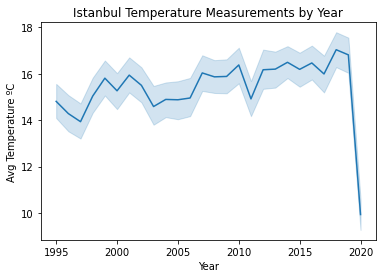

In [9]:
sns.lineplot(x = df["Year"], y = df["AvgTemperature"])
plt.ylabel("Avg Temperature ºC")
plt.title("Istanbul Temperature Measurements by Year")

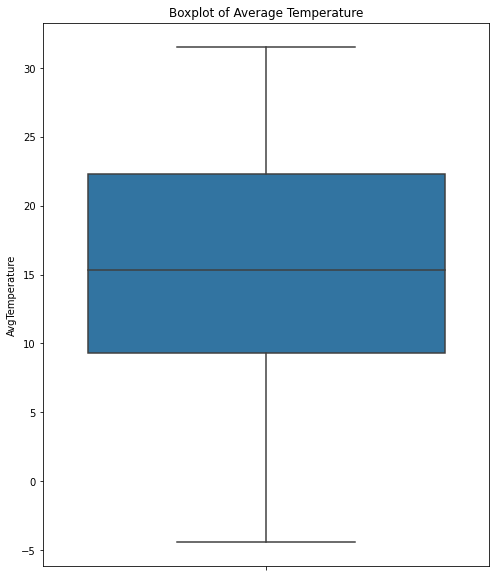

In [10]:
plt.figure(figsize = (8,10))
sns.boxplot(data = df,y = 'AvgTemperature')
_=plt.title("Boxplot of Average Temperature")

So, basically the average temperature for Istanbul is around 15 C changing seasonally. 

### Date process

The Year, Month and Day comes as a separate column, I merged them and create a new date variable. 

In [11]:
def make_date(row):
    return datetime(year = row['Year'], month = row['Month'], day = row['Day'])


df['ds'] = df.apply(make_date, axis=1)
df.head()
#df.set_index(df.ds,inplace=True)

,Region,Country,State,City,Month,Day,Year,AvgTemperature,ds
1102318,Middle East,Turkey,NaN,Istanbul,1,1,1995,12.777778,1995-01-01
1102319,Middle East,Turkey,NaN,Istanbul,1,2,1995,13.944444,1995-01-02
1102320,Middle East,Turkey,NaN,Istanbul,1,3,1995,6.888889,1995-01-03
1102321,Middle East,Turkey,NaN,Istanbul,1,4,1995,8.666667,1995-01-04
1102322,Middle East,Turkey,NaN,Istanbul,1,5,1995,6.722222,1995-01-05


We do not need all columns, so I only select temperature and date columns from the data set. I also make data column as the index. Here is the head and tail of the data set. 

In [13]:
df = df.rename(columns={'AvgTemperature': 'y'})
df = df[['ds', 'y']]

df.reset_index(drop=True, inplace=True)

df.head()
df.tail()


,ds,y
9261,2020-05-09,15.888889
9262,2020-05-10,17.500000
9263,2020-05-11,20.500000
9264,2020-05-12,21.944444
9265,2020-05-13,17.944444


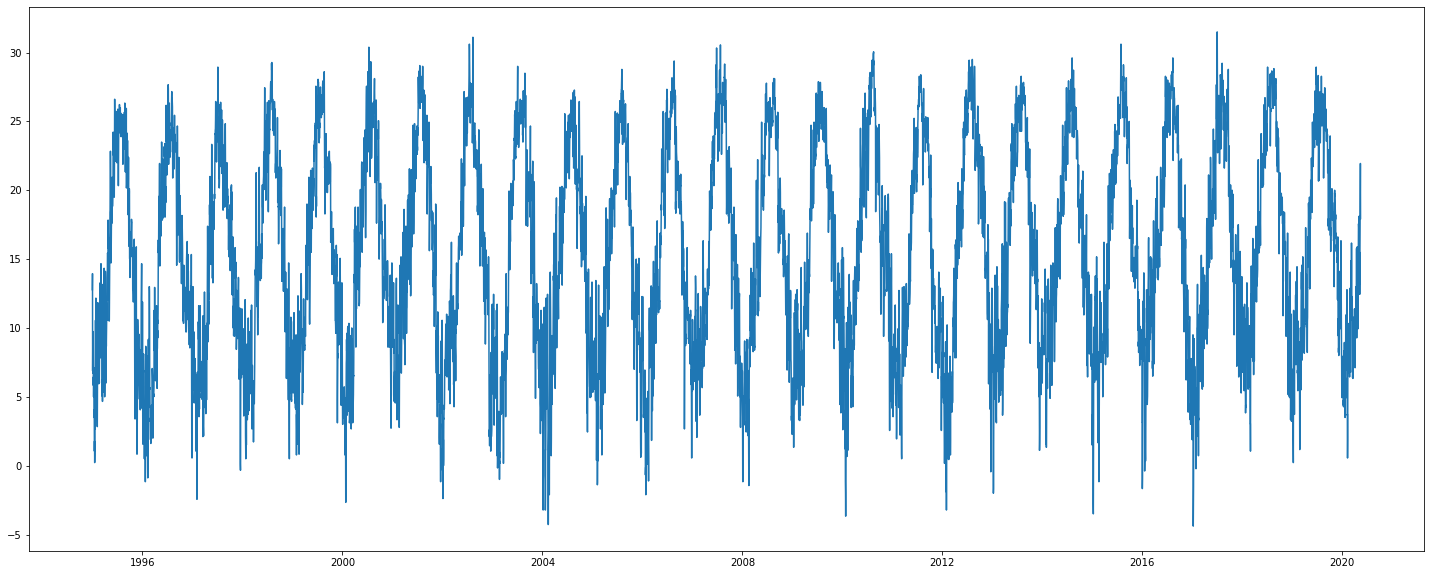

In [19]:
# probably there might be better way to visualize this gragh 
# but I could not handle date format with the current data set
df2=df

df2.columns = ['ds','y']
df2.y = df2.y.astype('float')
df2.ds = df2.ds.astype('datetime64')

plt.plot(df2.ds, df2.y)
plt.rcParams["figure.figsize"] = [20, 10]




# FB Prophet Model 

Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit and predict methods.
The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [20]:
# read daily page views for the Wikipedia page for Peyton Manning; scraped into hosted CSV
# conda install -c conda-forge fbprophet (to install)
from fbprophet import Prophet
plt.rcParams['figure.figsize'] = [14, 4]



# fit model
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
# forecast 365 days into future
# prophet requires a blank dataframe to input predictions
# will also provide blank set for dates within dataset to allow for fit
future = m.make_future_dataframe(periods=365)
print(future.head())
print(future.tail())

          ds
0 1995-01-01
1 1995-01-02
2 1995-01-03
3 1995-01-04
4 1995-01-05
             ds
9625 2021-05-09
9626 2021-05-10
9627 2021-05-11
9628 2021-05-12
9629 2021-05-13


In [23]:
# populate forecast
forecast = m.predict(future)
print(forecast.columns)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,yhat,yhat_lower,yhat_upper
9625,2021-05-09,18.015740,14.696872,21.529375
9626,2021-05-10,18.190678,14.901559,21.615141
9627,2021-05-11,18.363295,14.784982,21.956893
9628,2021-05-12,18.588042,14.954143,22.185761
9629,2021-05-13,18.831519,15.152858,22.238997


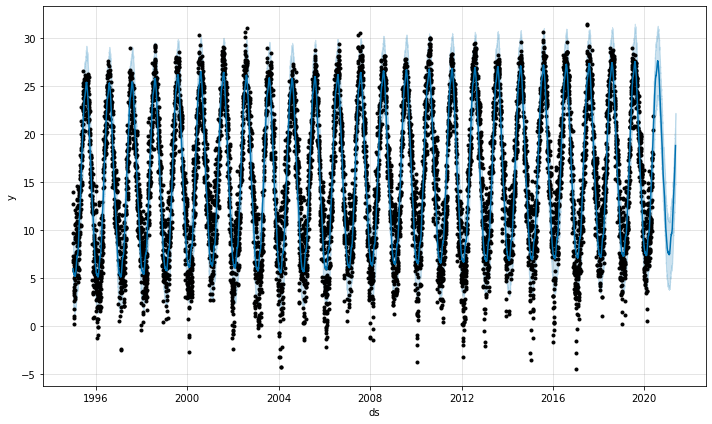

In [24]:
# plot forecast
m.plot(forecast);


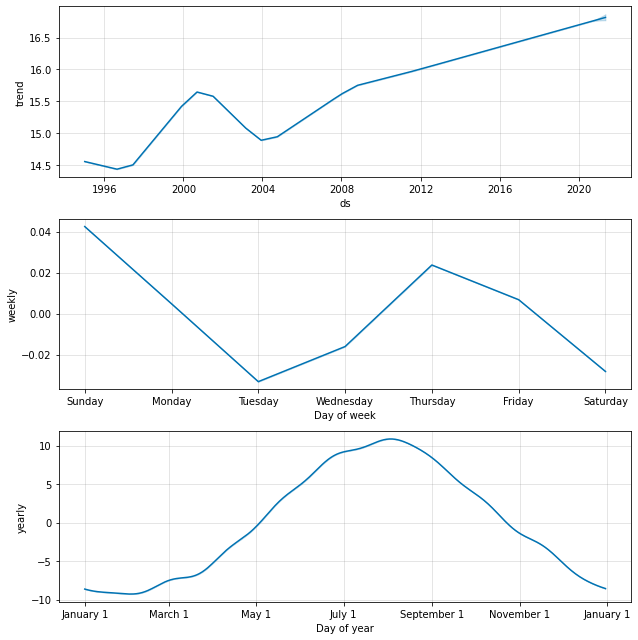

In [25]:
# plot individual components of forecast: trend, weekly/yearly seasonality,
m.plot_components(forecast);

According to trend graph, there has been a constant increase after 2004. It increased from 14.5 to 16.5 C, which represents more than 2 C change.

# Cross Validation

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values. 


This cross validation procedure can be done automatically for a range of historical cutoffs using the cross_validation function. We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.
The output of cross_validation is a dataframe with the true values y and the out-of-sample forecast values yhat, at each simulated forecast date and for each cutoff date. In particular, a forecast is made for every observed point between cutoff and cutoff + horizon. This dataframe can then be used to compute error measures of yhat vs. y.

In [26]:
from fbprophet.diagnostics import cross_validation
#Starting from 1000 days in, making a prediction every 365 days, 365 days into the future
df_cv = cross_validation(m, initial='1000 days', period='365 days', horizon = '365 days', parallel="processes")
df_cv.head()

INFO:fbprophet:Making 22 forecasts with cutoffs between 1998-05-19 00:00:00 and 2019-05-14 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f1ea963d250>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1998-05-20,18.758334,15.455642,22.146762,14.611111,1998-05-19
1,1998-05-21,18.832684,15.341826,22.130246,14.777778,1998-05-19
2,1998-05-22,18.939914,15.805305,22.561000,16.833333,1998-05-19
3,1998-05-23,18.954011,15.663347,22.217986,15.055556,1998-05-19
4,1998-05-24,18.941472,15.684861,22.321002,17.111111,1998-05-19


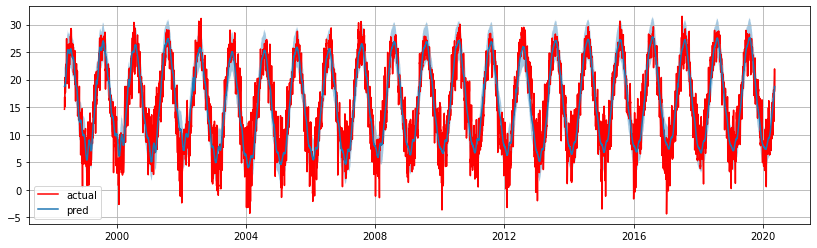

In [27]:
plt.plot(df_cv.ds,df_cv.y,label='actual', color= 'red')
plt.plot(df_cv.ds,df_cv.yhat,label = 'pred')
plt.fill_between(df_cv.ds,df_cv.yhat_lower,df_cv.yhat_upper,alpha=0.4)
plt.grid()
plt.legend()

#### Custom cutoff

Custom cutoffs can also be supplied as a list of dates to the cutoffs keyword in the cross_validation function in Python and R. For example, three cutoffs 12 months apart, would need to be passed to the cutoffs argument in a date format like:

In [28]:
#prediction for three years cut-off

cutoffs = pd.to_datetime(['2017-05-13', '2018-05-13', '2019-05-13'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')

  0%|          | 0/3 [00:00<?, ?it/s]

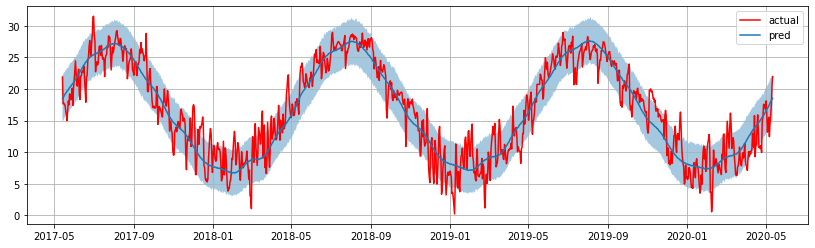

In [29]:
plt.plot(df_cv2.ds,df_cv2.y,label='actual', color= 'red')
plt.plot(df_cv2.ds,df_cv2.yhat,label = 'pred')
plt.fill_between(df_cv2.ds,df_cv2.yhat_lower,df_cv2.yhat_upper,alpha=0.4)
plt.grid()
plt.legend()

#### The Performance Metrics

The performance_metrics utility can be used to compute some useful statistics of the prediction performance (yhat, yhat_lower, and yhat_upper compared to y), as a function of the distance from the cutoff (how far into the future the prediction was).

The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), median absolute percent error (MDAPE) and coverage of the yhat_lower and yhat_upper estimates. 

These are computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff). By default 10% of the predictions will be included in each window, but this can be changed with the rolling_window argument.

In [30]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,37 days,4.828472,2.197378,1.746802,0.066873,0.895392
1,38 days,4.912925,2.216512,1.757424,0.066689,0.892902
2,39 days,4.964542,2.228125,1.761006,0.066689,0.893524
3,40 days,4.997375,2.235481,1.762258,0.065914,0.894147
4,41 days,5.032867,2.243405,1.766731,0.064716,0.892279


Cross validation performance metrics can be visualized with plot_cross_validation_metric, here shown for MAE. The MAPE is more preferred but as seen above, it is very closed to zero. 

Dots show the absolute percent error for each prediction in df_cv. The blue line shows the MAE, where the mean is taken over a rolling window of the dots.   

We see for this forecast that errors around 2% are typical for predictions one month into the future, and that errors increase up to around 11% for predictions that are a year out.

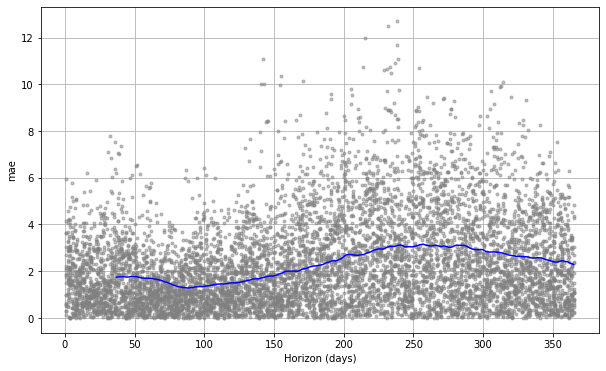

In [31]:
# Python
from fbprophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='mae')


# prediction

In [32]:
df1= df.copy()
df1['date'] = df['ds']
df1.set_index('date', inplace= True)
#df1['ds']= df.index




df1.head()


,ds,y
date,,
1995-01-01,1995-01-01,12.777778
1995-01-02,1995-01-02,13.944444
1995-01-03,1995-01-03,6.888889
1995-01-04,1995-01-04,8.666667
1995-01-05,1995-01-05,6.722222


In [33]:
# create a training set and a test set. We are only going to use last month's data to make everything a bit more clear
df_train = df1['2019' :'2020']
df_test = df1['2020-04':'2020-05-13']
print(df_train.tail())
print(df_test.tail())

                   ds          y
date                            
2020-05-09 2020-05-09  15.888889
2020-05-10 2020-05-10  17.500000
2020-05-11 2020-05-11  20.500000
2020-05-12 2020-05-12  21.944444
2020-05-13 2020-05-13  17.944444
                   ds          y
date                            
2020-05-09 2020-05-09  15.888889
2020-05-10 2020-05-10  17.500000
2020-05-11 2020-05-11  20.500000
2020-05-12 2020-05-12  21.944444
2020-05-13 2020-05-13  17.944444


In [34]:
# fit model
m = Prophet()
m.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
future = m.make_future_dataframe(periods = 60) # could also leave default freq of days and do 31 for period
print(future.head())
future.tail()

          ds
0 2019-01-01
1 2019-01-02
2 2019-01-03
3 2019-01-04
4 2019-01-05


,ds
554,2020-07-08
555,2020-07-09
556,2020-07-10
557,2020-07-11
558,2020-07-12


In [36]:
# populate forecast
forecast = m.predict(future)
print(forecast.columns)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,yhat,yhat_lower,yhat_upper
554,2020-07-08,16.634109,12.686773,20.451349
555,2020-07-09,16.749916,12.943325,20.669550
556,2020-07-10,16.611115,12.881154,20.300424
557,2020-07-11,16.607111,12.915440,20.696820
558,2020-07-12,16.770972,12.956419,20.955084


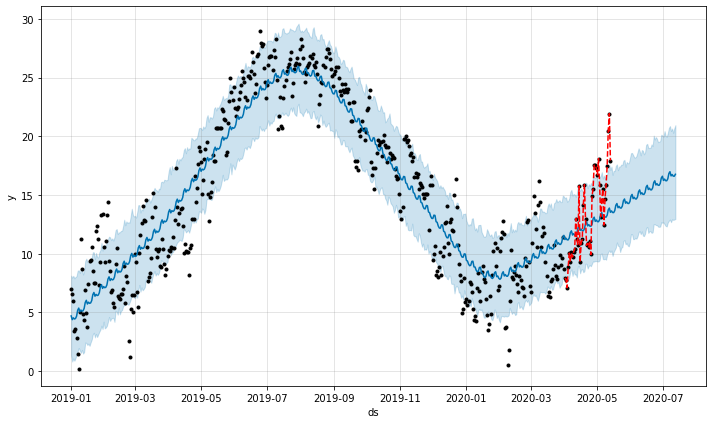

In [37]:
m.plot(forecast)
plt.plot(df_test.y,'r--')

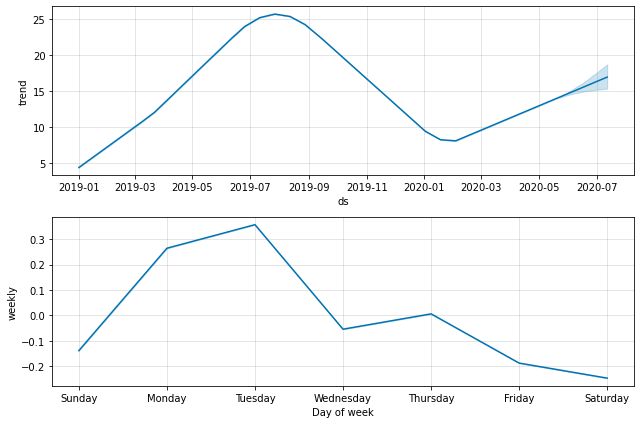

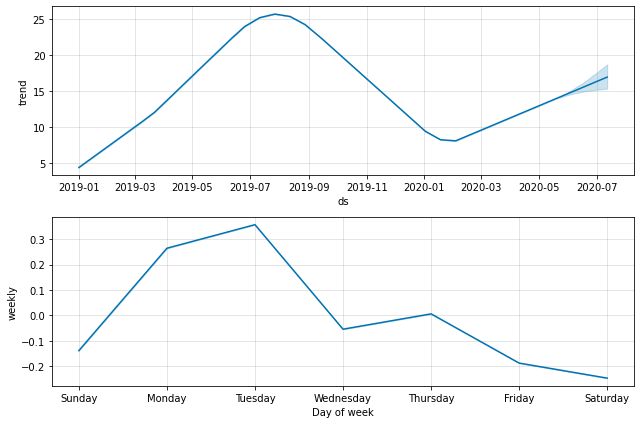

In [38]:
m.plot_components(forecast)

### Tuning

__seasonality_prior_scale:__ This parameter controls the flexibility of the seasonality. Similarly, a large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality. The default is 10., which applies basically no regularization. That is because we very rarely see overfitting here (there’s inherent regularization with the fact that it is being modeled with a truncated Fourier series, so it’s essentially low-pass filtered). A reasonable range for tuning it would probably be [0.01, 10]; when set to 0.01 you should find that the magnitude of seasonality is forced to be very small. This likely also makes sense on a log scale, since it is effectively an L2 penalty like in ridge regression.

__changepoint_range:__ This is the proportion of the history in which the trend is allowed to change. This defaults to 0.8, 80% of the history, meaning the model will not fit any trend changes in the last 20% of the time series. This is fairly conservative, to avoid overfitting to trend changes at the very end of the time series where there isn’t enough runway left to fit it well. With a human in the loop, this is something that can be identified pretty easily visually: one can pretty clearly see if the forecast is doing a bad job in the last 20%. In a fully-automated setting, it may be beneficial to be less conservative. It likely will not be possible to tune this parameter effectively with cross validation over cutoffs as described above. The ability of the model to generalize from a trend change in the last 10% of the time series will be hard to learn from looking at earlier cutoffs that may not have trend changes in the last 10%. So, this parameter is probably better not tuned, except perhaps over a large number of time series. In that setting, [0.8, 0.95] may be a reasonable range.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


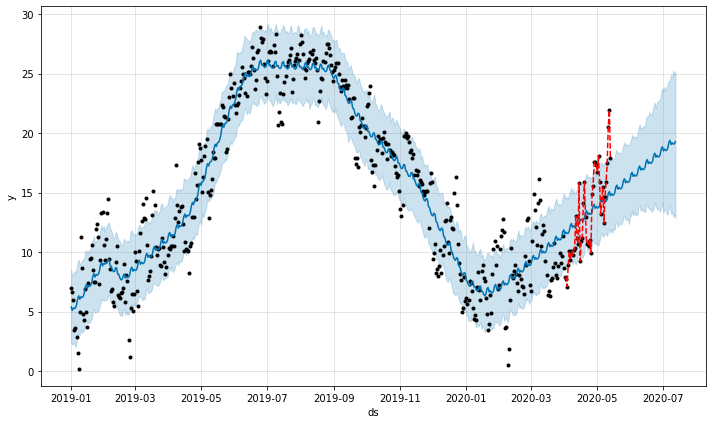

In [39]:

# Decreasted drastically from defaults
changepoint_prior_scale = 0.8
seasonality_prior_scale = 10


m = Prophet(daily_seasonality=10,
            
            seasonality_prior_scale=seasonality_prior_scale,
            changepoint_prior_scale=changepoint_prior_scale)
m.fit(df_train);


forecast = m.predict(future)
m.plot(forecast)
plt.plot(df_test.y,'r--')

# Summary

- I previously analyzed the same data with the [SARIMA model](https://github.com/ali-unlu/SARIMA-time-series-analysis/blob/main/Time%20series%20analysis.ipynb) and compared to that model, fbprophet model produce better results with less coding efforts. Fbprophet also supports regressor and holiday inputs, which make analyis more flexible for trend analysis. Since temperature is not affected from any of those, we did not use those inputs. 
- This model fits pretty well to the data set and prediction scores also works well. 
- We also use cross validation and it improved the mode. We have a better fitting line with the data. 
- We also train the data for future prediction. For this analysis, we predict one year (365 days) forecast. 
- In the next post, I will also use deep learning model for time series analysis. 

Please feel free to share your comments. 